# EDA and visualization of the Ten Thousand German News Articles Dataset
In this notebook I will explore the dataset using different visualizations libraries.
I'll use the articles.csv file (must be in project root folder)

## Imports

In [ ]:
# FOR COLAB : need to download some libraries
!pip install sentence-transformers umap-learn

In [99]:
# Data manipulation
from itertools import chain
import pandas as pd
import numpy as np
from collections import Counter
import re
import umap
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer
# NLP
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download as nltk_download
from sentence_transformers import SentenceTransformer
# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Only need to download the first time :
nltk_download('stopwords')
nltk_download('punkt')
spacy.cli.download("de_core_news_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


## Loading Dataset

In [4]:
articles_df = pd.read_csv('articles.csv', sep=';', header = None, names = ['label','text'])

In [5]:
articles_df

,label,text
0,Etat,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,Etat,App sei nicht so angenommen worden wie geplant...
2,Etat,"'Zum Welttag der Suizidprävention ist es Zeit,..."
3,Etat,Mitarbeiter überreichten Eigentümervertretern ...
4,Etat,Service: Jobwechsel in der Kommunikationsbranc...
...,...,...
10268,Wissenschaft,Die Fundstelle in Südengland ist Unesco-Weltku...
10269,Wissenschaft,Im Team arbeitet auch ein Inspektor der sudane...
10270,Wissenschaft,Die zentrale Frage des Projekts: Siedelten Ägy...
10271,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...


## Text Basic Statistics

First I will print some basic distributions in the dataset :
* Distribution at character level
* Distribution at word level
* Distribution of average word lengths

In [6]:
def plot_articles_distribution(df, bins, distribution):
    df.hist(bins=bins, xrot=90, figsize=(10,4))
    plt.xticks(bins)
    plt.xlabel(f'{distribution} in article')
    plt.ylabel('number of corresponding articles')
    plt.title(f'Distribution of {distribution} in articles')
    plt.show()

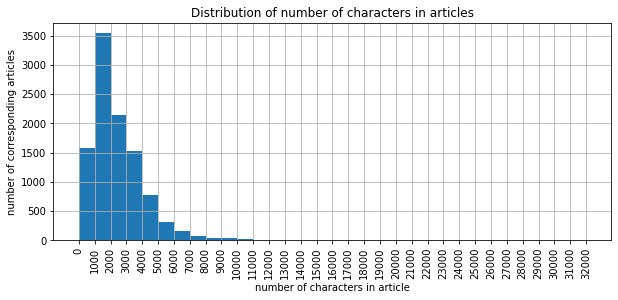

In [7]:
char_nb_df = articles_df['text'].str.len()
char_bins = [i for i in range(0,char_nb_df.max(),1000)]
plot_articles_distribution(char_nb_df, char_bins,'number of characters')

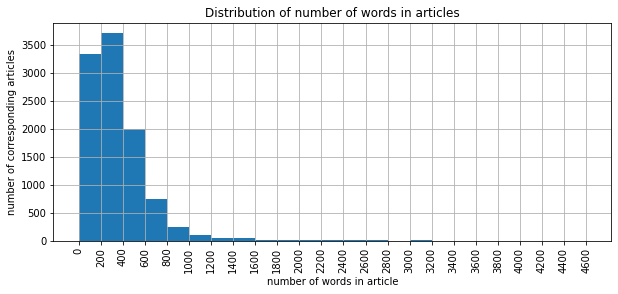

In [8]:
word_nb_df = articles_df['text'].str.split().map(lambda x: len(x))
word_bins = [i for i in range(0,word_nb_df.max(),200)]
plot_articles_distribution(word_nb_df, word_bins,'number of words')

The major part of the dataset has articles containing less than 600 words , this will be useful to know when we tokenize the news articles for BERT, as BERT has to define a maximum sequence length for his inputs (using padding or truncation if necessary). 

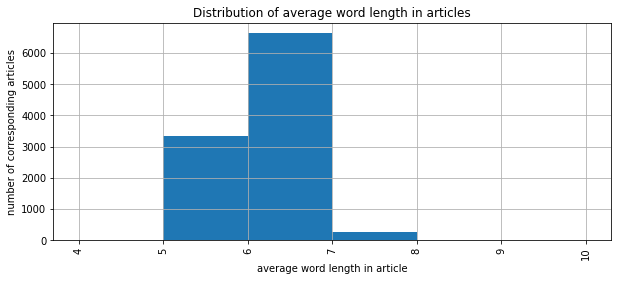

In [9]:
avg_word_len_df = articles_df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
avg_word_len_bins = [i for i in range(int(avg_word_len_df.min()),int(avg_word_len_df.max())+1,1)]
plot_articles_distribution(avg_word_len_df, avg_word_len_bins,'average word length')

German language usually has long words (lots of compound words compared to english) and the average number of character in german is 6.7 according to [this article](https://www.inter-contact.de/en/blog/text-length-languages?dt=1636454594184). So the articles we're using seems to follow this rule (the large majority of articles have an average word length between 5 and 8 words).

## Tokens frequency statistics

To analyze the frequency of tokens in the dataset, some preprocessing must first be performed : lowercasing, tokenization, punctuation and stopwords removal (I'll use NLTK here).

In [15]:
german_stopwords = stopwords.words('german')

def preprocess(text):
  text = text.lower() # lowercasing
  text = re.sub(r'[^\w\s]', '', text) # delete punctuation
  text_list = word_tokenize(text)
  text_list = [word for word in text_list if word not in german_stopwords]
  return text_list

In [16]:
preprocessed_text = articles_df.text.apply(preprocess)
words_list = list(chain(*preprocessed_text)) # itertools faster than Series.sum()

In [19]:
def plot_word_bargraph(word_counter, word_number=25, y_axis='tokens'):
  most=word_counter.most_common(word_number)
  x, y=[], []
  for word,count in most:
    x.append(word)
    y.append(count)
  plt.title(f'Most common {y_axis}')
  plt.xlabel('number in dataset')
  sns.barplot(x=y,y=x)
  plt.show()

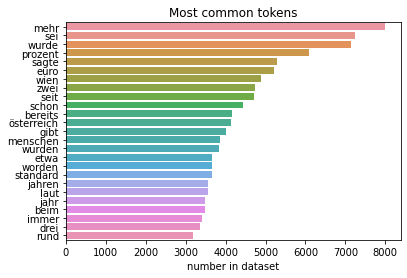

In [20]:
plot_word_bargraph(Counter(words_list))

Then I will try to see which non alpha tokens are mostly present in the dataset (to have insight about using number or not)

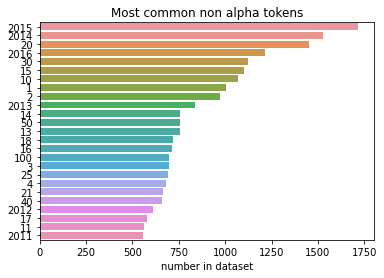

In [21]:
plot_word_bargraph(Counter([word for word in words_list if not word.isalpha()]), y_axis='non alpha tokens')

Non alpha tokens are mostly years , interesting fact is that years are sorted from most recent  (except for 2016,  it may be because the data was extracted during 2016 so there lacks a part of the year?); this can show that the numbers of articles published per year increase with time (with internet constant growth) .

## Named Entity Recognition

I will use spacy german small model to extract named entities. They can give a lot of cool insights about our dataset (most common organizations cited, persons, etc...)

In [42]:
# Loading spacy german model
nlp = spacy.load("de_core_news_sm", disable=['tagger','parser'], exclude=['tagger','parser'])

In [43]:
entities = articles_df.text.apply(lambda x: nlp(x).ents)
entities

0        ((ARD-Tochter), (ARD-Tochter), (August, Frauen...
1        ((Spiegel, Online), (Fußball-App), (App), (New...
2        ((Zum, Welttag, der, Suizidprävention), (Zeit)...
3        ((Wien), (APA-Mitarbeiter), (STANDARD), (APA-T...
4        ((Kommunikationsbranche), (derStandard.at/Etat...
                               ...                        
10268    ((Südengland), (Bodenradar, Mira), (Stonehenge...
10269    ((Amara, West), (Sudan), (Michelle), (kanadisc...
10270    ((Projekts), (Ägypter), (Nubier), (ägyptischen...
10271    ((Sahelzone), (Zeit), (Amara, West), (G322), (...
10272    ((Lebens), (Grabungshaus), (Skelette), (Amara-...
Name: text, Length: 10273, dtype: object

In [44]:
entities_list = list(chain(*entities)) # itertools faster than Series.sum()

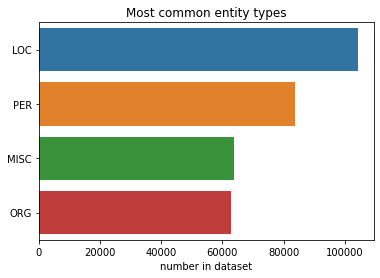

In [50]:
plot_word_bargraph(Counter([ent.label_ for ent in entities_list]), y_axis='entity types')

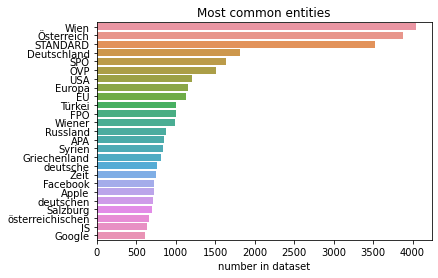

In [51]:
plot_word_bargraph(Counter([ent.text for ent in entities_list]), y_axis='entities')

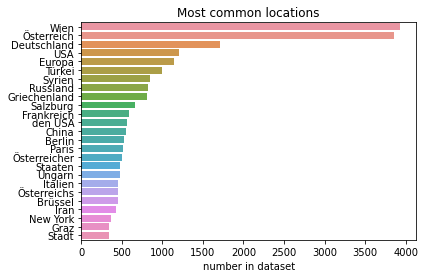

In [52]:
plot_word_bargraph(Counter([ent.text for ent in entities_list if ent.label_ == 'LOC']), y_axis='locations')

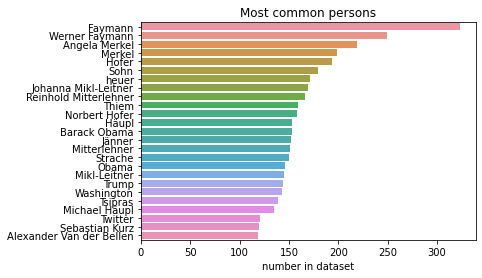

In [53]:
plot_word_bargraph(Counter([ent.text for ent in entities_list if ent.label_ == 'PER']), y_axis='persons')

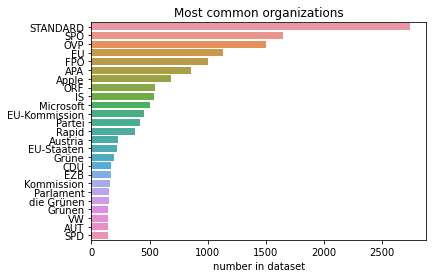

In [54]:
plot_word_bargraph(Counter([ent.text for ent in entities_list if ent.label_ == 'ORG']), y_axis='organizations')

## Classes Analyses

### Classes Repartition

First, we visualize the repartition of articles in the classes

,text
label,
Etat,668
Inland,1015
International,1511
Kultur,539
Panorama,1678
Sport,1201
Web,1677
Wirtschaft,1411
Wissenschaft,573


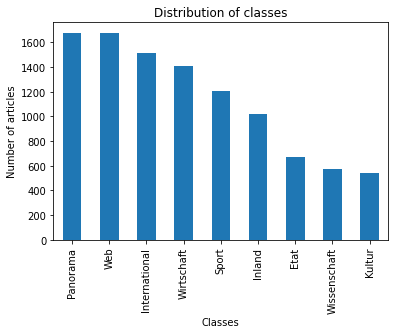

In [55]:
articles_df['label'].value_counts().plot(kind='bar', 
                                         title= 'Distribution of classes', 
                                         ylabel= 'Number of articles',
                                         xlabel= 'Classes')
articles_df.groupby(['label']).count()

We can see that classes are not balanced. So it will be important to take care of it during the train/test split (so that we have an even amount of each classes in train set and test set).

### Visualizing most frequent words in each class

In this part I will use Word Cloud visualization to see which words are the most frequent in each class

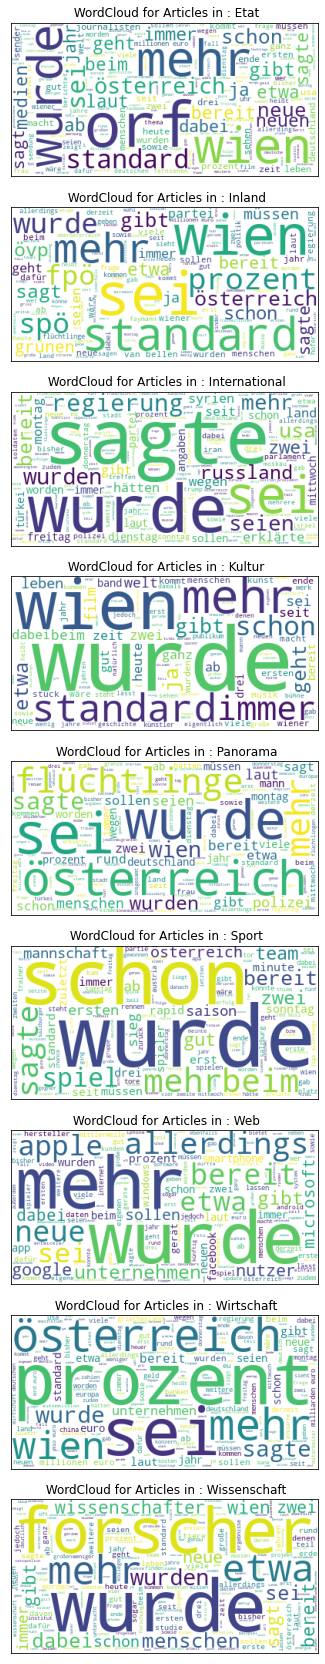

In [70]:
unique_labels = articles_df.label.unique() # array of unique labels
n_labels = len(unique_labels)# number of labels
fig, axes = plt.subplots(n_labels, 1, figsize=(30,30)) # initializing one plot for each label
i = 0
for label in unique_labels: # iterating through all labels
    # Getting all joined text from current label
    current_label_text = preprocessed_text[articles_df['label']==label]
    text = ' '.join(list(chain(*current_label_text)))
    # Generating word cloud from joined articles in current label
    wordcloud = WordCloud(background_color="white")
    wordcloud.generate(text)
    axes[i].imshow(wordcloud)
    # Removing x and y axis because useless when visualizing word clouds
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(" WordCloud for Articles in : " + label)
    i+=1

### Classes sentence embeddings visualizations

I will use a [Sentence-Transformer Pretrained Model](https://www.sbert.net/docs/pretrained_models.html) to embed the articles sentences and then reduce their dimensions using UMAP for visualization.
I chose one of the mutilingual models with best performance according to authors as there were no models for german specifically on sentence transformers.
You can run this step on GPU for faster encoding of articles.
I then perform topic modelling using tf-idf variant. All this step was inspired from this article

In [76]:
# Embedding articles using sentence transformers
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cuda') # run on CUDA for faster inference
embeddings = model.encode(articles_df.text, show_progress_bar=True)

Batches:   0%|          | 0/322 [00:00<?, ?it/s]

In [77]:
# Doing dimension reduction with UMAP
umap_embedding = umap.UMAP(n_neighbors = 30, random_state=42).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [81]:
ord = OrdinalEncoder()
num_labels = ord.fit_transform(articles_df['label'].values.reshape(len(articles_df['label']),1))
labels_mapping = [ord.inverse_transform(np.array([[i]]))[0][0] for i in range(n_labels)]
print("CLASS MAPPING :")
for i in range(n_labels):
  print(f"{i} --> {labels_mapping[i]}")

CLASS MAPPING :
0 --> Etat
1 --> Inland
2 --> International
3 --> Kultur
4 --> Panorama
5 --> Sport
6 --> Web
7 --> Wirtschaft
8 --> Wissenschaft


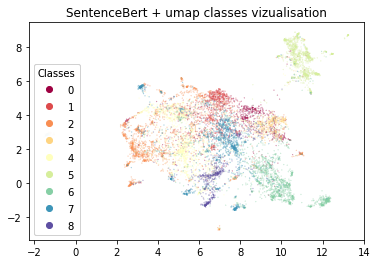

In [109]:
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding.T[0], umap_embedding.T[1], s=0.03, c=num_labels, cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.title("SentenceBert + umap classes vizualisation")
plt.show()

We can see that some classes are isolated from the others like class n°5 (Sport) or class n° 6 (Web) and others are a little bit mixed together (so they will probably be harder to classify). Indeed, as shown in the word clouds, some classes share the same most frequent words so some are more similar than others. Globally the colors representing the classes seems more or less clustered together so overall, after training, the model should perform correctly (even if it will not be trained with sentence transformers, this visulization can give some insight about the repartition of the articles)